# Analyses of fingerprints

In [1]:
prefix = '/home/ines/repositories/'
prefix = '/Users/ineslaranjeira/Documents/Repositories/'

In [2]:
""" 
IMPORTS
"""
import os
import numpy as np
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# --Machine learning and statistics

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler,  LabelBinarizer
import umap
from sklearn import mixture
import pickle
from scipy.stats import mode
from sklearn.metrics.pairwise import pairwise_distances
from scipy.cluster.hierarchy import fcluster
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import cosine
from sklearn.decomposition import PCA
from statsmodels.distributions.empirical_distribution import ECDF

# Get my functions
functions_path =  prefix + 'representation_learning_variability/Functions/'
os.chdir(functions_path)
# from data_processing import save_and_log
functions_path =  prefix + 'representation_learning_variability/Models/Sub-trial//2_fit_models/'
os.chdir(functions_path)
from preprocessing_functions import idxs_from_files
functions_path =  prefix + 'representation_learning_variability/Models/Sub-trial/4_analyses/5_clustering_analyses/'
os.chdir(functions_path)
# from clustering_functions import calculate_entropy
functions_path =  prefix + 'representation_learning_variability/Models/Sub-trial//3_postprocess_results/'
os.chdir(functions_path)
from plotting_functions import create_grouped_gradient_palette
from one.api import ONE
one = ONE(mode='remote')

In [ ]:
data_path = prefix + 'representation_learning_variability/paper-individuality/fig1_segmentation/'
states_file = pd.read_parquet(data_path+'states_trial_type_09-29-2025')
filename = str(data_path + 'all_sequences_09-29-2025')
all_sequences = pd.read_parquet(filename)
data_path = prefix + 'representation_learning_variability/paper-individuality/fig4_clustering/'
cluster_df = pd.read_parquet(data_path+'cluster_per_session')

In [ ]:
## Get sequences per trial epoch
all_sequences['session'] = all_sequences['sample'].str.split().str[:1].str.join('')
all_sequences = all_sequences.merge(cluster_df[['session', 'mouse_name', 'session_cluster']], on=['session', 'mouse_name'])

design_df = all_sequences.pivot(index=['sample', 'trial_type', 'mouse_name'], columns=['broader_label'], values='binned_sequence').reset_index().dropna()
var_names = design_df.keys()[-4:]
df = design_df.copy()
df['feedback'] = df['trial_type'].str.split().str[:1].str.join('')
df['choice'] = df['trial_type'].str.split().str[3:4].str.join('')
df['block'] = df['trial_type'].str.split().str[2:3].str.join('')
df['contrast'] = df['trial_type'].str.split().str[1:2].str.join('')
df['side'] = df['choice'].copy()
df.loc[(df['feedback']=='correct') & (df['choice']=='right'), 'side'] = 'left'
df.loc[(df['feedback']=='correct') & (df['choice']=='left'), 'side'] = 'right'
df['session'] = df['sample'].str.split().str[:1].str.join('')
df['trial_id'] = df['sample'].str.split().str[1:2].str.join('')

# Get timing info
vars = ['trial_id', 'session', 'mouse_name']
elongation = pd.DataFrame(states_file.groupby(vars)['elongation'].mean()).reset_index()
elongation['trial_id'] = elongation['trial_id'].astype(str)
response = pd.DataFrame(states_file.groupby(vars)['response'].mean()).reset_index()
response['trial_id'] = response['trial_id'].astype(str)
reaction = pd.DataFrame(states_file.groupby(vars)['reaction'].mean()).reset_index()
reaction['trial_id'] = reaction['trial_id'].astype(str)

# Merge
merged_df = df.merge(elongation, on=['session', 'trial_id', 'mouse_name'])
merged_df = merged_df.merge(response, on=['session', 'trial_id', 'mouse_name'])
merged_df = merged_df.merge(reaction, on=['session', 'trial_id', 'mouse_name'])
merged_df['contrast'] = merged_df['contrast'].astype(float)
merged_df['block'] = merged_df['block'].astype(float)

# Timing quantiles and choice
merged_df['response_qt'] = pd.qcut(merged_df['response'], 4, labels=False)/4
merged_df['elongation_qt'] = pd.qcut(merged_df['elongation'], 4, labels=False)/4
merged_df['choice'] = merged_df['trial_type'].str.split().str[3:4].str.join('')
merged_df.loc[merged_df['choice']=='left', 'choice'] = 0
merged_df.loc[merged_df['choice']=='right', 'choice'] = 1
merged_df.loc[merged_df['feedback']=='correct', 'feedback'] = 1
merged_df.loc[merged_df['feedback']=='incorrect', 'feedback'] = 0
del states_file

## Get sequences per trial

In [240]:
design_df = all_sequences.pivot(index=['sample', 'trial_type', 'mouse_name', 'session'], columns=['broader_label'], values='binned_sequence').reset_index().dropna()
var_names = design_df.keys()[-4:]

## Analyse clusters

(array([73.,  0., 30.,  0., 40.,  0., 30.,  0., 30., 15.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

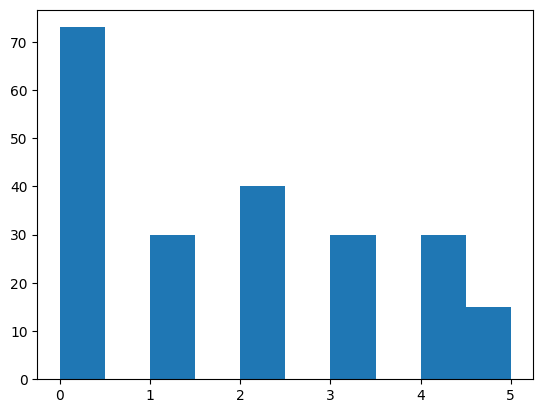

In [15]:
plt.hist(cluster_df['session_cluster'])

In [32]:
clusters = cluster_df['session_cluster']
epoch_to_analyse = ['Pre-quiescence', 'Quiescence', 'Choice', 'ITI']

sequences_choice = np.vstack(design_df[epoch_to_analyse].apply(lambda row: np.hstack(row), axis=1))  # Transpose to get the right shape
use_sequences = sequences_choice[~np.isnan(sequences_choice).any(axis=1)]


In [ ]:
use_states = len(np.unique(sequences_choice))
timesteps = 40
reshaped_probs = pd.DataFrame()

for c, cluster in enumerate(np.unique(clusters)):
    reshaped_probs_cluster = pd.DataFrame(columns=['syllable', 'timestep', 'cluster', 'prob'], index=range(use_states * timesteps))
    indices = np.where(clusters==cluster)[0]
    syllable_prob = np.array(cluster_df[cluster_df.keys()[2:-1]])[indices, :].mean(axis=0)

    for t in range(timesteps):
        reshaped_probs_cluster['syllable'][t*use_states:(t+1)*use_states] = ['000', '100', '200', '300', '400', '500', '600', '700', '010', '110',
                     '210', '310', '410', '510', '610', '710', '001', '101', '201', '301', '401', '501', '601', '701', '011',
                     '111', '211', '311', '411', '511',  '611',  '711']
        reshaped_probs_cluster['timestep'][t*use_states:(t+1)*use_states] = t
        reshaped_probs_cluster['prob'][t*use_states:(t+1)*use_states] = syllable_prob[t*use_states:(t+1)*use_states]
        reshaped_probs_cluster['cluster'][t*use_states:(t+1)*use_states] = cluster
    # Save
    reshaped_probs = pd.concat([reshaped_probs, reshaped_probs_cluster])

/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_5963/1332982467.py:13: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  reshaped_probs_cluster['syllable'][t*use_states:(t+1)*use_states] = ['000', '100', '200', '300', '400', '500', '6

In [41]:
order = ['000', '010', '001', '011', '100', '110', '101', '111', '200', '210', '201', '211',
         '300', '310', '301', '311', '400', '410',  '401', '411',
         '500', '510', '501', '511', '600', '610', '601', '611',
         '700', '710', '701', '711']
labels = ['VL00', 'VL10', 'VL01', 'VL11', 'Low00', 'Low10',  'Low01', 'Low11',
         'Lowish00', 'Lowish10', 'Lowish01', 'Lowish11', 
         'LL-00', 'LL-10', 'LL-01', 'LL-11', 'LR-00', 'LR-10', 'LR-01', 'LR-11', 
         'HL-00', 'HL-10', 'HL-01', 'HL-11', 'HR-00', 'HR-10', 'HR-01', 'HR-11', 
         'H-00', 'H-10', 'H-01', 'H-11']
rename_labels = dict(zip(np.array(order), np.array(labels)))
rename_func = np.vectorize(rename_labels.get)

/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_5963/657462440.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['syllable'] = rename_func(use_data['syllable'])
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/

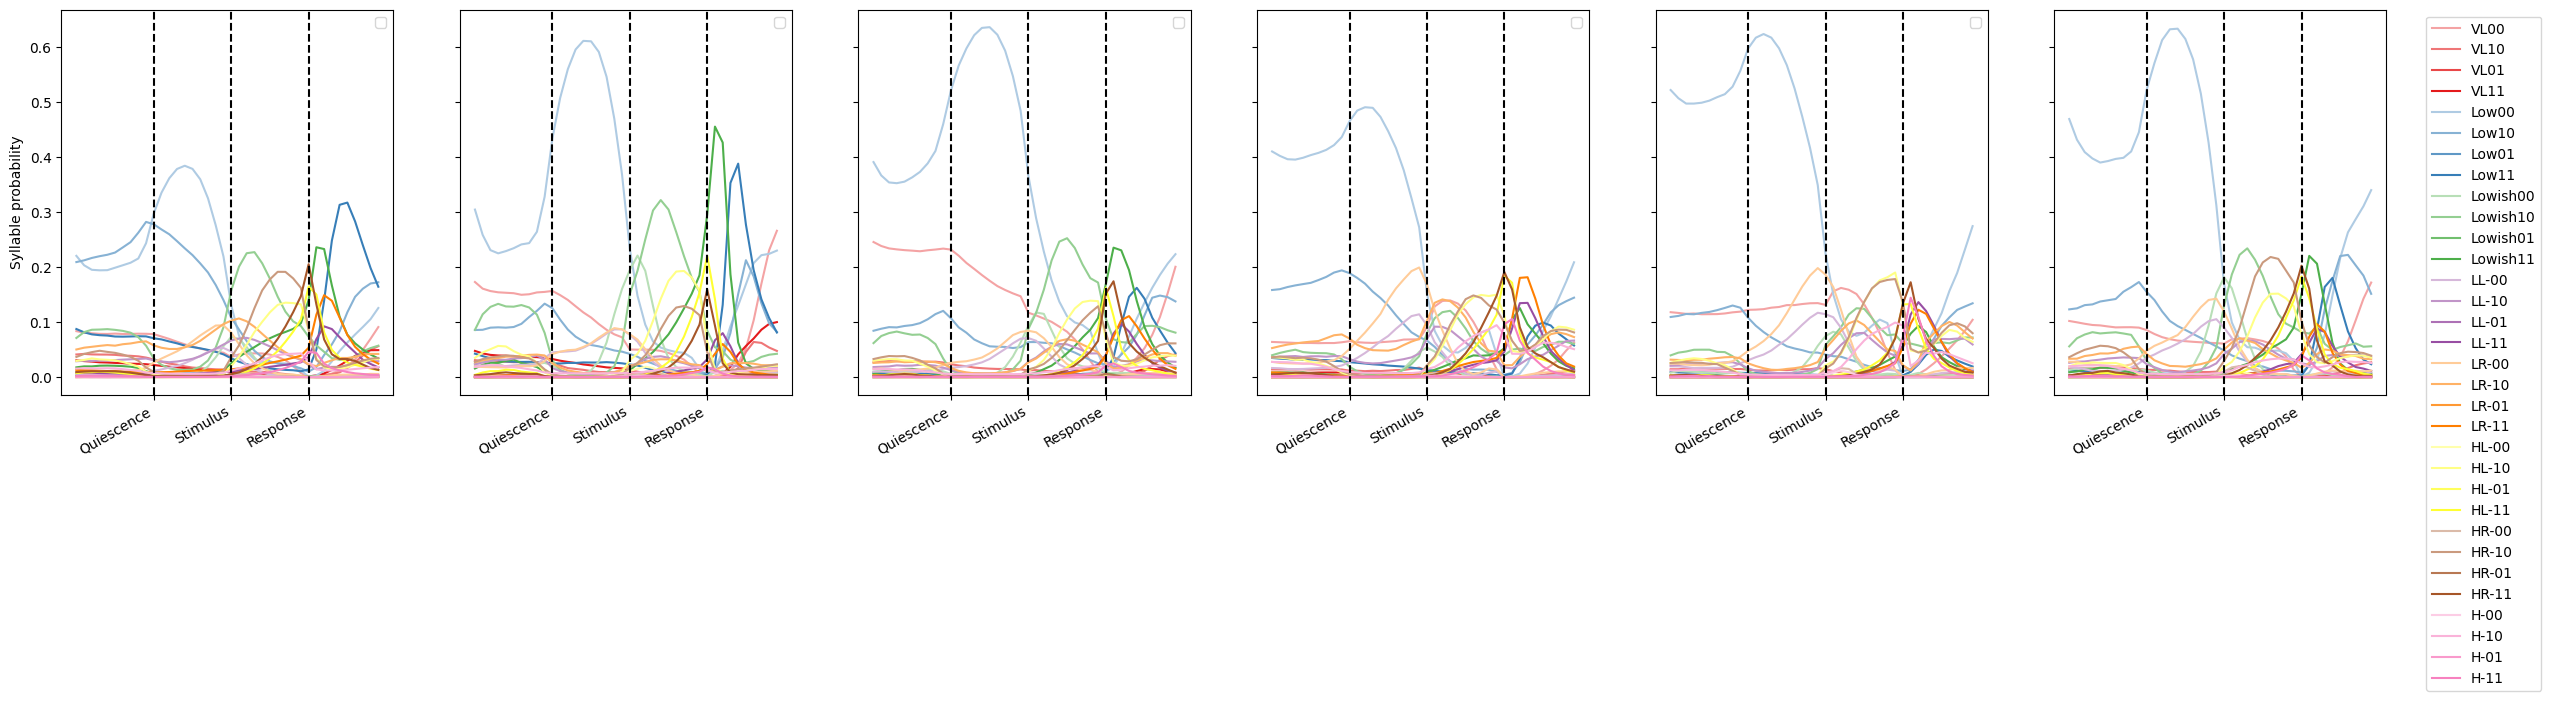

In [42]:
palette_16 = create_grouped_gradient_palette(n_groups=8, shades_per_group=4, base_palette='Set1')
palette_16_list = [palette_16(i) for i in range(palette_16.N)]  # Extract colors properly
state_to_color = dict(zip(order, palette_16_list))

fig, axs = plt.subplots(1, 6, sharex=True, sharey=True, figsize=(30, 5))
for c, cluster in enumerate(np.unique(clusters)):
    use_data = reshaped_probs.loc[reshaped_probs['cluster']==cluster]
    use_data['syllable'] = rename_func(use_data['syllable'])
    sns.lineplot(x='timestep', y='prob', hue='syllable', data=use_data, 
                ax=axs[c], palette=palette_16_list, hue_order=labels)  #  legend=labels[c]

    axs[c].axvline(x=10, color='k', linestyle='--')
    axs[c].axvline(x=20, color='k', linestyle='--')
    axs[c].axvline(x=30, color='k', linestyle='--')
    axs[c].set_ylabel('Syllable probability')
    axs[c].set_xlabel('')
    axs[c].set_xticks(np.arange(10, 31, 10), ['Quiescence', 'Stimulus', 'Response'], rotation=30, ha='right')
    axs[c].legend('')
axs[c].legend(loc='upper left', bbox_to_anchor=(1.1, 1))


/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_5963/2044453549.py:21: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x='timestep', y='prob', data=importances_syllable.loc[importances_syllable['cluster']==c],
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_5963/2044453549.py:21: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x='

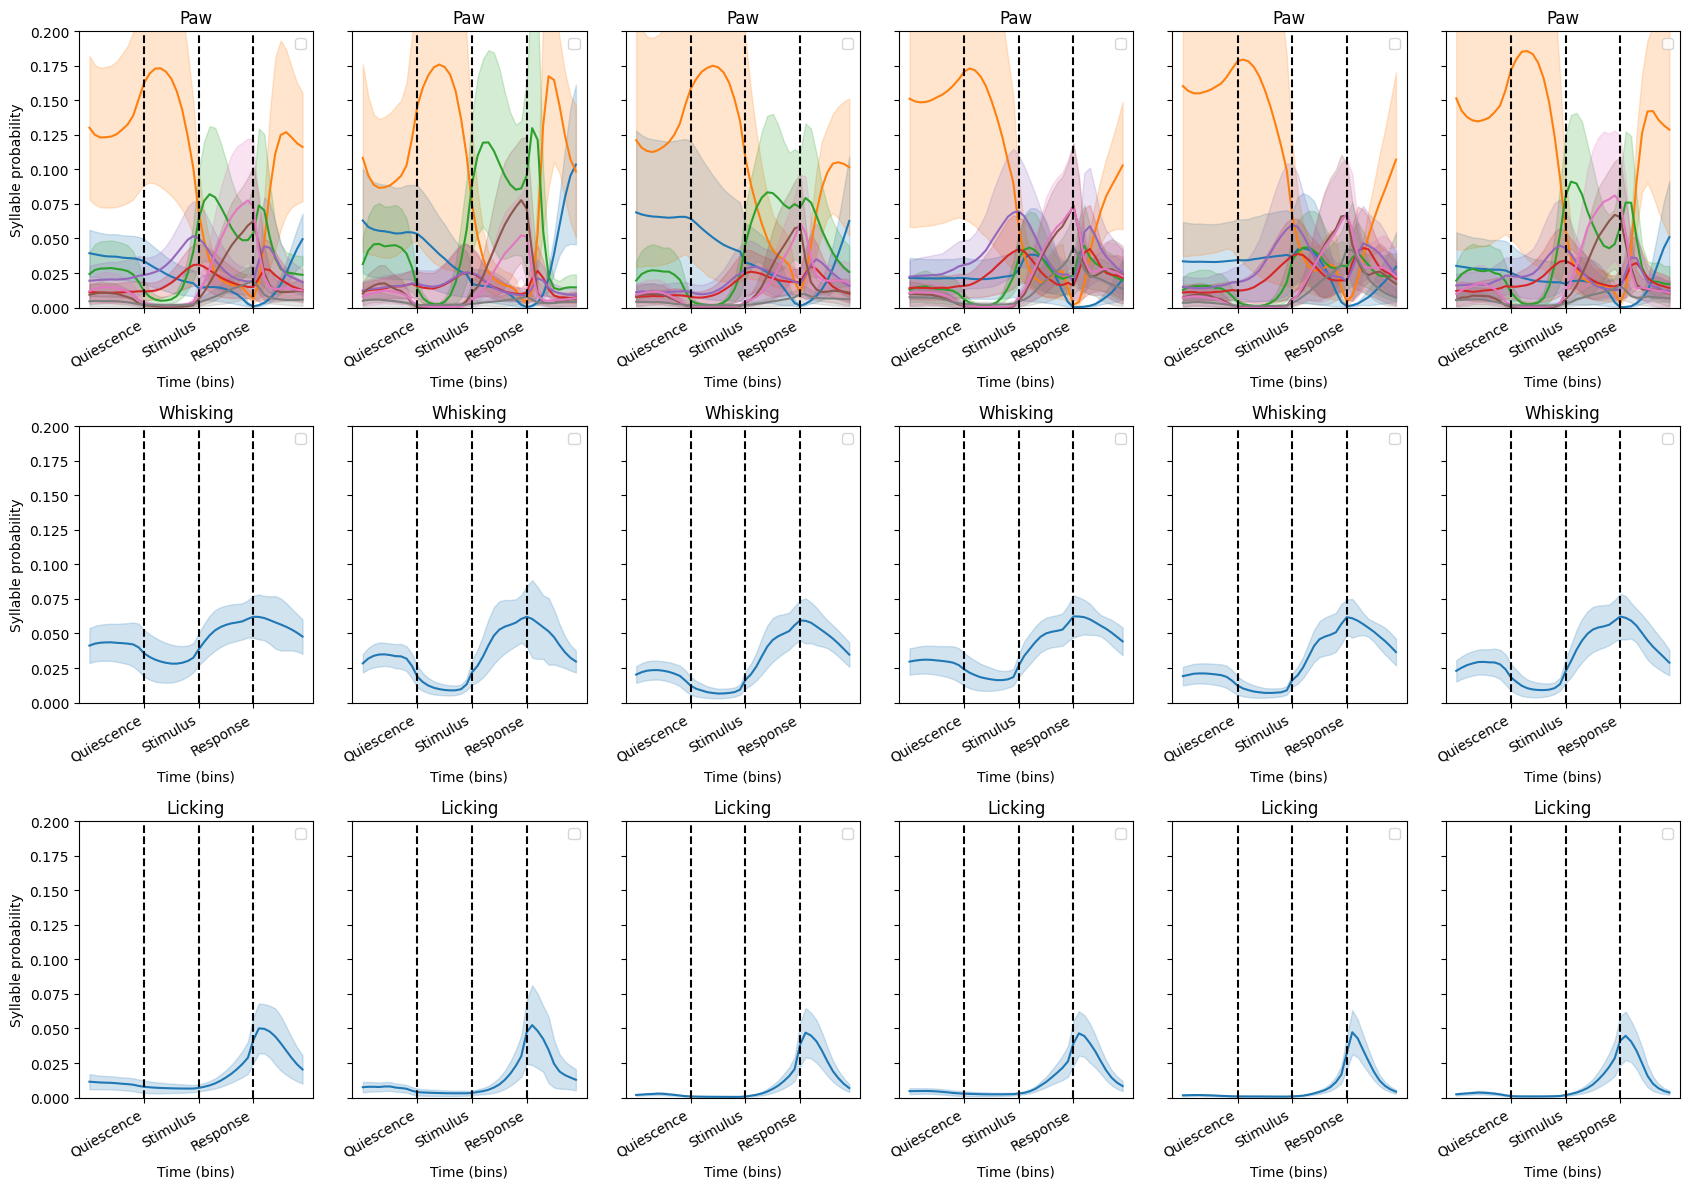

In [ ]:
epoch_to_analyse = ['Pre-quiescence', 'Quiescence', 'Choice', 'ITI']

color = sns.color_palette("Set1", 8, as_cmap=False)
palette_16 = create_grouped_gradient_palette(n_groups=8, shades_per_group=1, base_palette='Set1')
color = [palette_16(i) for i in range(palette_16.N)]  # Extract colors properly
fig, axs = plt.subplots(3, len(np.unique(clusters)), sharex=False, sharey=True, figsize=(17, 12))
syllables = np.array([[int(d) for d in s] for s in reshaped_probs['syllable']])
titles = ['Paw', 'Whisking', 'Licking']
for c in range(len(np.unique(clusters))):
    for i in range(3):
        unique_syllable_digits = np.unique(syllables[:, i])
        # if i == 0:
        #     unique_syllable_digits = np.sort(paw_func(unique_syllable_digits))
        for u in unique_syllable_digits:
            if len(unique_syllable_digits)==2 and u == 0:
                continue
            syllable_interest = np.where(syllables[:, i]==u)
            importances_syllable = reshaped_probs.reset_index().loc[syllable_interest]
            # remapped_paw_syllable = paw_func(u)
            remapped_paw_syllable = u
            sns.lineplot(x='timestep', y='prob', data=importances_syllable.loc[importances_syllable['cluster']==c], 
                ax=axs[i, c], errorbar='se', palette=color[u], label=str(remapped_paw_syllable))
        axs[i, c].set_title(titles[i])
        axs[i, c].set_ylim([0, 0.2])
        axs[i, c].set_xlabel('Time (bins)')
        axs[i, c].set_ylabel('Syllable probability')
        axs[i, c].axvline(x=10, color='k', linestyle='--')
        axs[i, c].axvline(x=20, color='k', linestyle='--')
        axs[i, c].axvline(x=30, color='k', linestyle='--')
        # axs[i, c].legend(loc='upper left', bbox_to_anchor=(1.1, 1))
        axs[i, c].legend('')
        axs[i, c].set_xticks(np.arange(10, 31, 10), ['Quiescence', 'Stimulus', 'Response'], rotation=30, ha='right')
plt.tight_layout()

## Plot histograms per cluster

In [352]:
optimal_k = 8
if optimal_k == 8:
    identifiable_mapping = {'000': 0.0,
           '100': 1.0,
           '200': 2.0,
           '300': 3.0,
           '400': 4.0,
           '500': 5.0,
           '600': 6.0,
           '700': 7.0,
           
           '010': 8.0,
           '110': 9.0,
           '210': 10.0,
           '310': 11.0,
           '410': 12.0,
           '510': 13.0,
           '610': 14.0,
           '710': 15.0,

           '001': 16.0,
           '101': 17.0,
           '201': 18.0,
           '301': 19.0, 
           '401': 20.0, 
           '501': 21.0, 
           '601': 22.0, 
           '701': 23.0, 

           '011': 24.0,
           '111': 25.0,
           '211': 26.0,
           '311': 27.0,
           '411': 28.0,
           '511': 29.0,
           '611': 30.0,
           '711': 31.0,
           'nan': np.nan
           }
    # paw_mapping = {0:4, 1:1, 2:5, 3:7, 4:6, 5:2, 6:0, 7:3}
    paw_mapping = {0:1, 1:5, 2:3, 3:0, 4:6, 5:4, 6:7, 7:2}  # original

elif optimal_k == 5:
    identifiable_mapping = {'000': 0.0,
           '100': 1.0,
           '200': 2.0,
           '300': 3.0,
           '400': 4.0,
           
           '010': 5.0,
           '110': 6.0,
           '210': 7.0,
           '310': 8.0,
           '410': 9.0,

           '001': 10.0,
           '101': 11.0,
           '201': 12.0,
           '301': 13.0, 
           '401': 14.0, 

           '011': 15.0,
           '111': 16.0,
           '211': 17.0,
           '311': 18.0,
           '411': 19.0,
           'nan': np.nan
           }
    paw_mapping = {0:1, 1:2, 2:4, 3:0, 4:3} 
inverted_mapping = {v: k for k, v in identifiable_mapping.items()}
inverted_func = np.vectorize(inverted_mapping.get)

In [ ]:
palette_16 = create_grouped_gradient_palette(n_groups=8, shades_per_group=4, base_palette='Set1')
palette_16_list = [palette_16(i) for i in range(palette_16.N)]  # Extract colors properly
ordered_identifiable = ['000', '010', '001', '011',
                        '100', '110', '101', '111', 
                        '200', '210', '201', '211',
                        '300', '310', '301', '311',
                        '400', '410', '401', '411',  
                        '500', '510', '501', '511',
                        '600', '610', '601', '611',
                        '700', '710', '701', '711'
                   ]
ordered_numbers = np.arange(0, 32, 1)
rename_labels = dict(zip(np.array(ordered_identifiable), np.array(ordered_numbers)))
rename_func = np.vectorize(rename_labels.get)

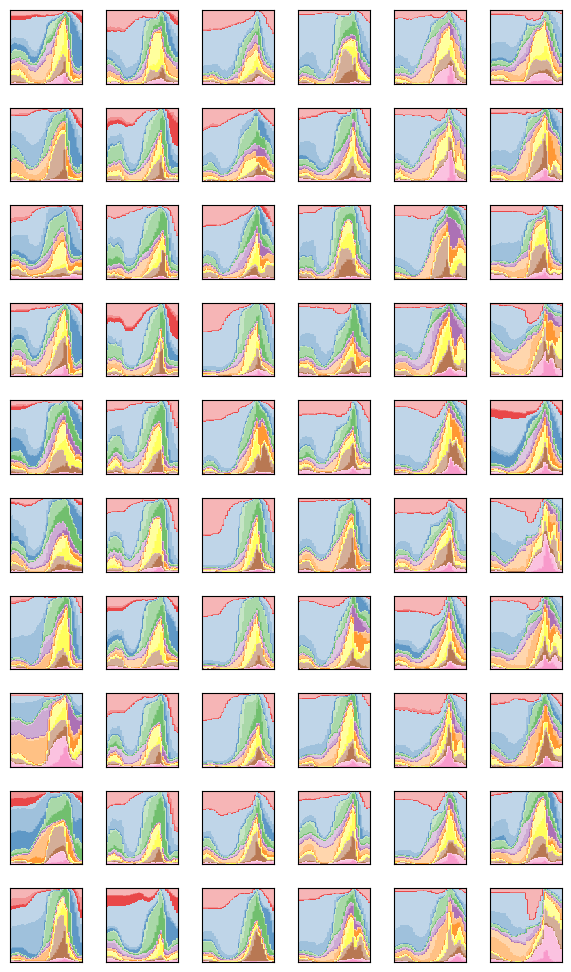

In [355]:
sessions_to_process = all_sequences['session'].unique()
new_sequences = all_sequences.merge(full_session_syllables[['session', 'session_cluster']], on='session')
epoch_to_analyse = ['Pre-quiescence', 'Quiescence', 'Choice', 'ITI']
hvormye = 10
fig, axs = plt.subplots(hvormye, len(np.unique(final_clusters)), sharex=False, sharey=False, figsize=(6, hvormye))

for c, cluster in enumerate(range(len(np.unique(final_clusters)))):
    cluster_sessions = np.random.choice(new_sequences.loc[new_sequences['session_cluster']==cluster, 'session'].unique(), hvormye, replace=False)
    for m, mat in enumerate(cluster_sessions):
        session = mat
        mouse_data = new_sequences.loc[(new_sequences['session']==session) & (new_sequences['session_cluster']==cluster)]
        bound = int(np.shape(mouse_data)[0]/4)
        mouse_seq = np.ones((bound, 40)) * np.nan
        all_epochs = []
        try:
            for e, epoch in enumerate(epoch_to_analyse):
                epoch_data = np.vstack(mouse_data.loc[mouse_data['broader_label']==epoch, 'binned_sequence'].values)[:bound, :]
                epoch_data = inverted_func(epoch_data)
                epoch_data = rename_func(epoch_data)
                if e == 0:
                    all_epochs = epoch_data[:bound-50, :]
                else:
                    all_epochs = np.concatenate([all_epochs, epoch_data[:bound-50, :]], axis=1)
            # sorted = all_epochs[np.argsort([ordered_dict[row[0]] for row in all_epochs])]
            axs[m, c].imshow(np.sort(all_epochs, axis=0), aspect='auto', cmap=palette_16, interpolation=None, alpha=0.8)
            axs[m, c].set_xticks([], [])
            axs[m, c].set_yticks([], [])
        except:
             axs[m, c].set_xticks([], [])
             axs[m, c].set_yticks([], [])
             print(mat)
plt.tight_layout()
plt.show()

In [222]:
file_to_save = new_df.copy()
filename = "cluster_per_session_dendogram"
save_path = '/home/ines/repositories/representation_learning_variability/Models/Sub-trial/4_analyses/'
file_format = 'parquet'
script_name = '4.8_clustering_session_sequences_dendogram.ipynb'
metadata = save_and_log(file_to_save, filename, file_format, save_path, script_name)

In [400]:
new_df.keys()

Index(['sample', 'trial_type', 'mouse_name', 'Choice', 'ITI', 'Pre-quiescence',
       'Quiescence', 'feedback', 'choice', 'block', 'contrast', 'side',
       'session', 'trial_id', 'elongation', 'response', 'reaction',
       'response_qt', 'elongation_qt', 'session_cluster', 'index',
       'training_time', 'log_training'],
      dtype='object')

## Correlates of session clusters

In [389]:
new_df = merged_df.merge(full_session_syllables[['session', 'session_cluster']], on='session')

In [304]:
data_path = prefix + 'representation_learning_variability/DATA/'
# data_path =  '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/DATA/'
learning_df = pd.read_csv(data_path+'learning_private_one.csv')
learning_times = learning_df[['subject_nickname', 'training_time']].drop_duplicates()
learning_times = learning_times.rename(columns={"subject_nickname": "mouse_name"}).reset_index()

data_path =  prefix + 'representation_learning_variability/DATA/'
learning_df = pd.read_parquet(data_path+'training_time_03-21-2025', engine='pyarrow')
learning_times_new = learning_df.rename(columns={"subject_nickname": "mouse_name"}).reset_index()

# new_df = design_df.droplevel(1, axis=1)[['mouse_name', 'session']]
# df = new_df.merge(learning_times, on='mouse_name')
a = learning_times.merge(learning_times_new, on='mouse_name', how='outer')
b = a.loc[a['training_time_x'].isna()]
b = b.rename(columns={"training_time_y": "training_time"}).reset_index()

full_learning = pd.concat([learning_times[['mouse_name', 'training_time']], b[['mouse_name', 'training_time']]]).reset_index()

/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_95551/1096352341.py:3: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  learning_df = pd.read_csv(data_path+'learning_private_one.csv')


In [390]:
new_df = new_df.merge(full_learning, on='mouse_name')

In [391]:
new_df['log_training'] = np.log(new_df['training_time'])

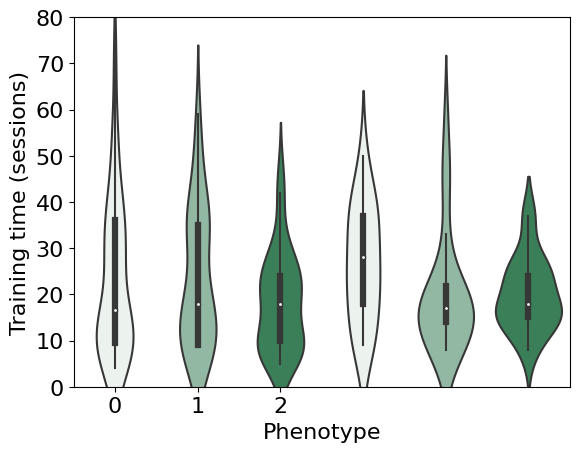

P-value for KW: 0.298
     0    1         2         3         4    5
0  1.0  1.0  1.000000  1.000000  1.000000  1.0
1  1.0  1.0  1.000000  1.000000  1.000000  1.0
2  1.0  1.0  1.000000  0.365911  1.000000  1.0
3  1.0  1.0  0.365911  1.000000  0.851726  1.0
4  1.0  1.0  1.000000  0.851726  1.000000  1.0
5  1.0  1.0  1.000000  1.000000  1.000000  1.0


In [ ]:
# --Machine learning and statistics
from scipy.stats import ttest_ind
from sklearn.metrics import f1_score
from scipy.stats import pearsonr
from scipy.stats import ttest_ind
import scikit_posthocs as sp
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy import stats

var_1 = 'training_time ~ session_cluster'
var = 'training_time'
var = 'feedback'
var_1 = 'feedback ~ session_cluster'
# Define the model using ordinary least squares (OLS) and fit it
# data = df.dropna()
# data = df.loc[df['mouse_name'].isin(filter_mice)].dropna()
data = pd.DataFrame(new_df.groupby(['mouse_name', 'session', 'session_cluster'])[var].mean()).reset_index().dropna()
# data = pd.DataFrame(new_df.groupby(['mouse_name', 'session_cluster'])[var].mean()).reset_index().dropna()
# data = data[['session_cluster', var]]
data[var] = data[var].astype(float)

model = ols(var_1, data=data).fit()

# Perform the ANOVA
anova_table = sm.stats.anova_lm(model, typ=2)  # Type 2 ANOVA DataFrame

# print(anova_table)

# Perform Tukey's HSD test
tukey = pairwise_tukeyhsd(endog=data[var], groups=data['session_cluster'], alpha=0.05)
# print(tukey)

plt.rcParams.update({'font.size': 16})
sns.violinplot(x='session_cluster', y=var, data=data, palette=sns.light_palette("seagreen", 3, as_cmap=False))
# sns.barplot(x='session_cluster', y=var, data=data, palette=sns.light_palette("seagreen", 3, as_cmap=False))
# sns.scatterplot(x='part_cluster', y=var, data=data, color='black')
plt.xticks([0, 1, 2], [0, 1, 2])
plt.ylim([0, 80])
# plt.ylim([0, 4])
# plt.ylim([0.5, 1])
# plt.ylim([0, 1])
plt.xlabel('Phenotype')
plt.ylabel('Proportion correct')
plt.ylabel('Training time (sessions)')
plt.show()

group_1 = data.loc[data['session_cluster']==0, var]
group_2 = data.loc[data['session_cluster']==1, var]
group_3 = data.loc[data['session_cluster']==2, var]
group_4 = data.loc[data['session_cluster']==3, var]
group_5 = data.loc[data['session_cluster']==4, var]
group_6 = data.loc[data['session_cluster']==5, var]

# stat, p_value = stats.kruskal(group_1, group_2, group_3, group_4)
stat, p_value = stats.kruskal(group_1, group_2, group_3)
# stat, p_value = stats.kruskal(group_1, group_2, group_3, group_4, group_5)
stat, p_value = stats.kruskal(group_1, group_2, group_3, group_4, group_5, group_6)
# stat, p_value = stats.kruskal(group_1, group_2)

print(f"P-value for KW: {p_value:.3f}")

posthoc = sp.posthoc_dunn(data.dropna(), val_col=var, group_col='session_cluster', p_adjust='bonferroni')
print(posthoc)